In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error
import joblib

from ML_utils.ML_functions import *


np.warnings.filterwarnings('ignore')

In [29]:
# Constants
toy_gt_path = '../toy dataset/groundtruth_toydataset.csv'
toy_input_path = '../toy dataset/input_toydataset-xyzrnaic.txt'
nonzero_gt_path = '../nonzerogt_dataset/groundtruth_nonzerogt.csv'
nonzero_input_path = '../nonzerogt_dataset/input_nonzerogt.txt'
full_gt_path = '../fullblock_dataset/groundtruth_fullblock.csv'
full_input_path = '../fullblock_dataset/input_fullblock.txt'

scaler_path = "../fullblock_dataset/scaler.joblib"
rf_path = "../fullblock_dataset/random_forest.joblib"

In [30]:
# Hyperparameters
groundtruth_datapath = toy_gt_path                                  # Where the groundturh data is stored
groundtruth_columns = ['x', 'y', 'CC']                              # Groundturth data columns
groundtruth_precision = 20                                          # Groundturth precision in meters
point_p_d2 = groundtruth_precision/2

input_datapath = toy_input_path                                     # Where the input data is storedº
input_columns = ['x','y','z', 'r', 'n', 'a','i','c']                                  # Input data columns
outliers = 135

In [31]:
# LiDAR and groundtruth reading
my_block = pd.read_csv(input_datapath, sep=' ', header = None, names = input_columns)
groundtruth = pd.read_csv(groundtruth_datapath, sep=' ', header = None, names = groundtruth_columns)

t1_load = time.time()

t0_adjust = time.time()

In [32]:
# Adjusting the groundtruth. CC cannot exceed 100
groundtruth['CC'] = [x if x<100 else 100 for x in groundtruth['CC']]

In [33]:
# Removing outliers
my_block = my_block.query('c != @outliers')

aux_xp = my_block['x'] // point_p_d2
aux_yp = my_block['y'] // point_p_d2

my_block['x_p'] = aux_xp * point_p_d2 + point_p_d2 * ( 1 - ( aux_xp % 2 ) )
my_block['y_p'] = aux_yp * point_p_d2 + point_p_d2 * ( 1 - ( aux_yp % 2 ) )

In [34]:
# Creating the final dataset
data = groundtruth.copy()
    # Necessary in order to merge later
data.rename(columns={"x": "x_p", "y": "y_p"}, inplace=True)

t1_adjust = time.time()

In [35]:
# Creating the feature extractor object
t0_FE = time.time()
FE = FeatureExtractor(my_block, 6)

In [36]:
# Adding the features to the dataset

features = [FE.mean_height(), FE.num_pixels(), FE.num_ground(), FE.num_low_vegetation(), FE.num_medium_vegetation(),
           FE.num_high_vegetation(), FE.num_building(), FE.max_height_diff(), FE.height_second_max(), FE.sd_height(),
           FE.not_cassified_pts(), FE.angle_mean(), FE.angle_sd(), FE.angle_max_diff() ]


t_aux1 = time.time()
for q in np.arange(0, 1, 0.1):
    features.append(FE.angle_quantile(q))
    
for q in np.arange(0, 1, 0.1):
    features.append(FE.height_quantile(q))
    
for t in np.arange(2, 6, 0.5):
    features.append(FE.threshold_percentage(t))
    
# Appending all features
for feature in features:
    data = data.merge(feature, how='left', on=['x_p', 'y_p'])
t_aux2 = time.time()

data.fillna(0, inplace=True)
coord_cols = data[['x_p','y_p']]
data.drop(['x_p','y_p'], axis=1, inplace=True)

t1_FE = time.time()

In [37]:
data

,CC,mean_height,num_pixels,num_ground,num_low_vegetation,num_medium_vegetation,num_high_vegetation,num_building,max_height_diff,height_second_max,...,height_Q0.8,height_Q0.9,above_threshold_pct_2.0,above_threshold_pct_2.5,above_threshold_pct_3.0,above_threshold_pct_3.5,above_threshold_pct_4.0,above_threshold_pct_4.5,above_threshold_pct_5.0,above_threshold_pct_5.5
0,63.66,6.995334,163,3.0,13.0,13.0,94.0,0.0,21.9098,21.9098,...,14.57012,16.19196,79.166667,79.166667,74.166667,64.166667,63.333333,61.666667,61.666667,60.000000
1,63.66,6.995334,163,3.0,13.0,13.0,94.0,0.0,21.9098,21.8298,...,14.57012,16.19196,79.166667,79.166667,74.166667,64.166667,63.333333,61.666667,61.666667,60.000000
2,0.00,1.226660,156,27.0,11.0,10.0,16.0,0.0,10.2000,10.2000,...,2.84980,3.15510,83.783784,75.675676,48.648649,21.621622,16.216216,16.216216,13.513514,8.108108
3,0.00,1.226660,156,27.0,11.0,10.0,16.0,0.0,10.2000,8.7404,...,2.84980,3.15510,83.783784,75.675676,48.648649,21.621622,16.216216,16.216216,13.513514,8.108108
4,0.00,0.488175,155,22.0,3.0,0.0,0.0,0.0,2.5197,2.5197,...,0.72978,0.95174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,100.00,8.539928,195,1.0,9.0,3.0,109.0,0.0,18.6001,18.5401,...,15.69610,16.95586,90.909091,88.429752,85.950413,85.950413,85.950413,85.123967,85.123967,84.297521
1900,100.00,8.118208,184,1.0,14.0,1.0,103.0,0.0,17.4003,17.4003,...,14.34400,15.07216,94.067797,90.677966,90.677966,87.288136,86.440678,86.440678,85.593220,85.593220
1901,100.00,8.118208,184,1.0,14.0,1.0,103.0,0.0,17.4003,16.6003,...,14.34400,15.07216,94.067797,90.677966,90.677966,87.288136,86.440678,86.440678,85.593220,85.593220
1902,91.96,6.079339,193,4.0,11.0,7.0,95.0,0.0,15.4803,15.4803,...,10.68006,11.94830,93.805310,89.380531,87.610619,86.725664,85.840708,82.300885,82.300885,82.300885


In [38]:
# Attributes-Target division
X = data.loc[:, data.columns != "CC"]
y = data['CC']

In [39]:
# Data normalization
scaler = joblib.load(scaler_path) #Loading scaler

std_X = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [40]:
# Loading RF
rf = joblib.load(rf_path) #Loading model

y_pred = rf.predict(std_X)


R2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("Random Forest Metrics:")
print("=="*50)
print('R2 score:', R2)
print("=="*50)
print('MAE score:', mae)

Random Forest Metrics:
R2 score: 0.855734855986287
MAE score: 11.564682247899158


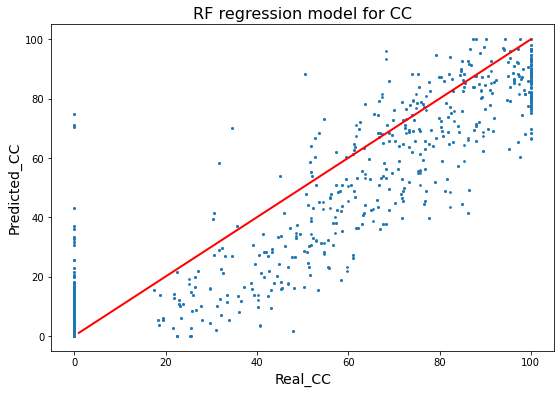

In [25]:
plt.rcParams["figure.figsize"] = (9,6)
plt.scatter(x=y, y=y_pred, s=3)
plt.plot([1,100], [1,100], color="red", linewidth=2)
plt.xlabel("Real_CC", fontsize=14)
plt.ylabel("Predicted_CC", fontsize=14)
plt.title("RF regression model for CC", fontsize=16)
plt.show()

In [ ]:
## Sending data to files

# X_test = X_test.drop(set(X_test.columns)-set(['x_p','y_p']), axis=1)
# data['Predicted_CC'] = y_pred.to_numpy()

# data[['x_p','y_p','CC','Predicted_CC']].to_csv(path_or_buf='./Predicted_CC.csv', sep=' ', header=False, index=False)
